# MLLAB project Recommand System -- chengcheng Guo


### load data

In [65]:
import numpy as np
# load data
data = np.load('dataset.npy')

In [56]:
# user, Item , Rating
data

array([[   2,  566,    1],
       [   2,  750,    2],
       [   2,  391,    1],
       ...,
       [5498,  516,    2],
       [5498,  650,    3],
       [5498,  651,    2]])

In [41]:
shape_d = data.shape
print("data shape is : ",shape_d)

data shape is :  (380311, 3)


In [87]:
# Getting the counts of  users ,items ,rates
import pandas as pd
df = pd.DataFrame(data)

users, items, ratings = df.nunique()
print("we have %d users"%users)
print("we have %d items"%items)
print("we have %d ratings"%ratings)

we have 1643 users
we have 1194 items
we have 5 ratings


In [89]:
print("biggest user id: ", np.max(data[:,0]))
print("biggest item id: ", np.max(data[:,1]))

biggest user id:  5498
biggest item id:  2079


In [43]:
np.mean(data[:,2])

0.3963046033377946

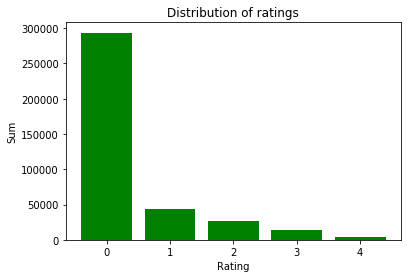

In [67]:
import matplotlib.pyplot as plt
# Plot histogram
unique, counts = np.unique(data[:,2], return_counts=True)
plt.bar(unique, counts, align='center', color = "green")
plt.xticks(unique)
plt.xlabel('Rating')
plt.ylabel('Sum')
plt.title('Distribution of ratings')
plt.show()

In [99]:
# TODO: Split data into train and test data
from sklearn.model_selection import train_test_split
# Add 1 to the rating to distinguish no rating and 0
data[:,2]=data[:,2]+1

X_train, X_test= train_test_split(data, test_size=0.2)

In [100]:
# reconstruct dense matrix to Sparse matrix 
from scipy.sparse import csr_matrix

def sparse_matrix(data):
    return csr_matrix((data[:,2], (data[:,0].astype(int), data[:,1].astype(int))))

In [101]:
Xtrain_sparse = sparse_matrix(X_train)
Xtest_sparse  = sparse_matrix(X_test)

In [74]:
# Baseline Predictors method b(u,i) = u + b(u) + b(i)
mean_train = csr_matrix.sum(Xtrain_sparse)/csr_matrix.count_nonzero(Xtrain_sparse)

### KNN

Here we want to use the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) as a measure for correlation between two items.



\begin{eqnarray}
\operatorname{sim}(i, j) & = & \frac{\sum_{u \in \operatorname{InJ}}\left(r_{u i}-\mu_{i}\right)\left(r_{u j}-\mu_{j}\right)}{\sqrt{\sum_{u \in \operatorname{InJ}}\left(r_{u i}-\mu_{i}\right)^{2}} \sqrt{\sum_{u \in I \cap J}\left(r_{u j}-\mu_{j}\right)^{2}}}
\end{eqnarray}

In [138]:
from tqdm.notebook import tqdm

In [ ]:
def Pearson_corr(matrix):
    # Calculate average ratings of ith item across users
    user_num, item_num = matrix.shape
    count_nonzeros = [csr_matrix.count_nonzero(matrix[:,i]) for i in range(item_num)]
    
    r_ui = csr_matrix.sum(matrix, axis = 0)
    mue_item = [0 if count_nonzeros[i] == 0 else r_ui[0,i]/count_nonzeros[i] for i in range(item_num)]
    
    Corr = np.full(shape=(item_num,item_num),fill_value=-float('inf'),dtype=float)
    # Calculate Pearson correlation matrix
    for i in tqdm(range(item_num)):
        u = np.squeeze(matrix[:,i].toarray())
        mue_u=mue_item[i]
        u = [(u[n] - mue_item[i]) if u[n] > 0 else 0 for n in range(user_num)]
        u_d = np.sqrt(np.dot(u,u))
        for j in range(i,item_num):
            u2 = np.squeeze(matrix[:,i].toarray())
            mue_u2=mue_item[i]
            u2 = [(u2[n] - mue_item[i]) if u2[n] > 0 else 0 for n in range(user_num)]
            u2_denominator = np.sqrt(np.dot(u2,u2))
            # calculate numerator of Item similarity function
            sim_numerator = np.dot(u,u2)
            
            sim_d = u_d*u2_denominator
            if sim_d!=0:
                sim=sim_numerator/sim_denominator
            else:
                sim=-float('inf')
            Corr[i,j]=sim
            Corr[j,i]=sim
                        
    return Corr

In [ ]:
%%time
Pearson_corr(Xtrain_sparse)

In [ ]:
%%time
Pearson_corr(Xtest_sparse)

In [71]:
# KNN method predicts ratings
def KNN(k, matrix, spa_matrix, mean_item, Corr, pred):
    for i in range(len(matrix)):
        Interaction = matrix[i,:]
        UserID=Interaction[0].astype(int)
        ItemID=Interaction[1].astype(int)
        # Get the row of ratings from the selected userID in sparse matrix
        User_row = np.squeeze(spa_matrix[UserID,:].toarray())
        Rated_items = np.array(np.squeeze(np.nonzero(User_row)),ndmin=1) # indices of non zero ratings
        sim_all = Corr[ItemID,Rated_items] # all the similarities between current Item and rated Items
        sorted_items = Rated_items[np.argsort(sim_all)[::-1]] # sorted item ID in descending order
        sorted_sims = sim_all[np.argsort(sim_all)[::-1]] # corresponding sorted similarities in descending order
        k_items = sorted_items[0:min(k,len(sorted_items)-1)]
        k_sims = sorted_sims[0:min(k,len(sorted_items)-1)]
        k_sims = np.clip(k_sims,0,1)
        k_ratings = User_row[k_items]
        k_mean = mean_item[k_items]
        weighted_sum = np.dot(k_sims, np.subtract(k_ratings,k_mean))
        if np.sum(np.abs(k_sims)) > 0:
            pred[i] = mean_item[ItemID] + weighted_sum/np.sum(np.abs(k_sims))
    pred = np.clip(pred,1,5)
    return pred

In [70]:
def rmse(Y, Y_hat):
    # TODO: calculate RMSE
    return np.sqrt(np.mean((Y-Y_hat)**2))